In [67]:
import pandas as pd
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

## Single feature to conjunction

In [72]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 5
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2c = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2c.nsub,num_labels=2)

In [73]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan


for isub,sub in enumerate(sync_s2c.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2c.load_eeg(sub)
    
    for xdata,ydata in sync_s2c.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2c.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2c.average_trials(xdata,ydata)
        xdata_train,xdata_test,ydata_train,ydata_test = sync_s2c.group_data(xdata,ydata)
        
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [74]:
interp_s2c = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_set_size_trialbin{trial_average}_')
# interp.save_results()
# interp.load_results('single_feature_to_conj_set_size_trialbin20_20200530_1334.pickle')

## Single feature to single feature

In [75]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 5
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2s = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2s.nsub,num_labels=2)

In [76]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2s.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2s.load_eeg(sub)
    
    for xdata,ydata in sync_s2s.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2s.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2s.average_trials(xdata,ydata)
        xdata,ydata = sync_s2s.group_data(xdata,ydata) # check if this is correct or should be group labels?
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [77]:
interp_s2s = decode_eeg.Interpreter(clfr, subtitle = f'single_feat_set_size_trialbin{trial_average}_')
# interp.save_results()
# interp.load_results('binning_single_feat_set_size_20200423_1355.pickle')

## Prepping conf mat data

In [78]:
# get confusions matrices, and drop subjects who aren't in both datasets
conj_conf = interp_s2c.conf_mat
sing_conf = interp_s2s.conf_mat
remove_subs_idx = np.isin(sync_s2s.matched_ids,sync_s2c.matched_ids)
sing_conf = sing_conf[remove_subs_idx]

In [79]:
# gets normalized predictions. Percent of trials of given condition predicted as 1 or 2.
def get_norm_sub_means(conf,ss):
    sub_means = np.mean(np.mean(conf[:,ss][:,wrangl.t>250],2),1)[:,0]
    norm_sub_means = np.empty(sub_means.shape)
    for i in range(sub_means.shape[0]):
        norm_sub_means[i] = (sub_means[i] / sum(sub_means[i]))
    
    return norm_sub_means

In [94]:
# get confusion matrices in dataframe
confs = [conj_conf,sing_conf]
labels = ['single12_1','single12_2','single24_2','single24_4','conj12_1','conj12_2','conj24_2','conj24_4']
i=0
df = pd.DataFrame()
for conf in confs:
    for s in range(2):
        cm = get_norm_sub_means(conf,s)
        df[labels[i]] = cm[:,0]
        i +=1
        df[labels[i]] = cm[:,1]
        i +=1
df.head()

,single12_1,single12_2,single24_2,single24_4,conj12_1,conj12_2,conj24_2,conj24_4
0,0.397500,0.602500,0.3125,0.6875,0.592500,0.407500,0.801250,0.198750
1,0.655000,0.345000,0.7625,0.2375,0.667500,0.332500,0.666250,0.333750
2,0.555000,0.445000,0.7000,0.3000,0.590000,0.410000,0.673750,0.326250
3,0.632143,0.367857,0.4975,0.5025,0.626667,0.373333,0.468333,0.531667
4,0.632500,0.367500,0.5950,0.4050,0.531250,0.468750,0.577500,0.422500


## 1&2

In [90]:
# tidy format dataframe of set size 1 vs 2.
percent_predicted = np.concatenate((df['single12_1'],df['single12_2'],df['conj12_1'],df['conj12_2']))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

tidy = pd.DataFrame()
tidy['feat'] = feat
tidy['ss'] = ss
tidy['percent_predicted'] = percent_predicted

tidy

,feat,ss,percent_predicted
0,single,low,0.397500
1,single,low,0.655000
2,single,low,0.555000
3,single,low,0.632143
4,single,low,0.632500
...,...,...,...
75,conj,high,0.326389
76,conj,high,0.356667
77,conj,high,0.265000
78,conj,high,0.381667


In [91]:
model = ols('percent_predicted ~ C(feat) + C(ss) + C(feat):C(ss)', data=tidy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),9.648881e-31,1.0,8.596972e-29,1.000000e+00
C(ss),1.846885e+00,1.0,1.645540e+02,1.058912e-20
C(feat):C(ss),2.329330e-04,1.0,2.075389e-02,8.858327e-01
Residual,8.529921e-01,76.0,NaN,NaN


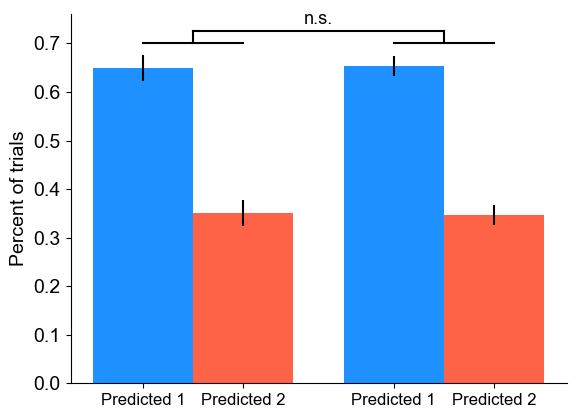

In [83]:
import matplotlib.pyplot as plt
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Predicted 1','Predicted 2','Predicted 1','Predicted 2']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(1 - width/2, group_means.filter(items=['single12_1']), width, color = 'dodgerblue', yerr=group_se.filter(items=['single12_1']))
rects2 = ax.bar(1 + width/2, group_means.filter(items=['single12_2']), width, color='tomato',yerr=group_se.filter(items=['single12_2']))
rects3 = ax.bar(2.25 - width/2, group_means.filter(items=['conj12_1']), width, color = 'dodgerblue',yerr=group_se.filter(items=['conj12_1']))
rects4 = ax.bar(2.25 + width/2, group_means.filter(items=['conj12_2']), width, color='tomato',yerr=group_se.filter(items=['conj12_2']))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

# plt.savefig('pred_double_12.pdf',dpi=1000)
# plt.savefig('pred_double_12.png',dpi=1000)
plt.show()

In [84]:
import winsound
winsound.PlaySound("SystemExit",winsound.SND_ALIAS)

## 2&4

In [92]:
percent_predicted = np.concatenate((df['single24_2'],df['single24_4'],df['conj24_2'],df['conj24_4']))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

tidy = pd.DataFrame()
tidy['feat'] = feat
tidy['ss'] = ss
tidy['vals'] = percent_predicted

In [93]:
model = ols('percent_predicted ~ C(feat) + C(ss) + C(feat):C(ss)', data=tidy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),1.474540e-30,1.0,8.743099e-29,1.000000e+00
C(ss),2.761129e+00,1.0,1.637176e+02,1.209695e-20
C(feat):C(ss),2.937834e-02,1.0,1.741952e+00,1.908535e-01
Residual,1.281754e+00,76.0,NaN,NaN


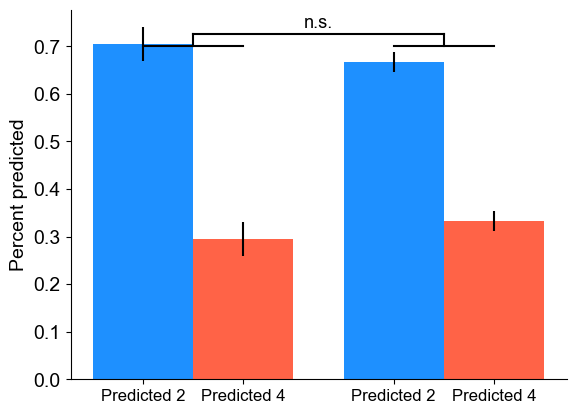

In [85]:
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Predicted 2','Predicted 4','Predicted 2','Predicted 4']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(1 - width/2, group_means.filter(items=['single24_2']), width, color = 'dodgerblue', yerr=group_se.filter(items=['single24_2']))
rects2 = ax.bar(1 + width/2, group_means.filter(items=['single24_4']), width, color='tomato',yerr=group_se.filter(items=['single24_4']))
rects3 = ax.bar(2.25 - width/2, group_means.filter(items=['conj24_2']), width, color = 'dodgerblue',yerr=group_se.filter(items=['conj24_2']))
rects4 = ax.bar(2.25 + width/2, group_means.filter(items=['conj24_4']), width, color='tomato',yerr=group_se.filter(items=['conj24_4']))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent predicted', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

# plt.savefig('pred_double_24.pdf',dpi=1000)
# plt.savefig('pred_double_24.png',dpi=1000)
plt.show()